In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize, Bounds
import matplotlib.pyplot as plt
from datetime import date, datetime
from tqdm.notebook import tqdm_notebook
import math
import time
# import pyfolio as pf
%matplotlib inline

In [3]:
def get_data(assets, start_date, end_date, time_interval):
    return yf.download(assets, 
                          start = start_date, 
                          end = end_date,
                          interval = time_interval,
                          threads = True,
                          progress = False)['Adj Close']

def get_data_full(assets, start_date, end_date, time_interval):
    return yf.download(assets, 
                          start = start_date, 
                          end = end_date,
                          interval = time_interval,
                          threads = True,
                          progress = False)

In [4]:
assets  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
           'REM', "VNQ", "RWX", # re
           'TIP', "IEF", "TLT", "BWX", #fi
           'DBC', "GLD", #como
           'twtr', 'intc', 'tsm',"VWUSX"]


# ----------- DATES ------
start_train_date = '2020-01-01'
end_train_date = '2021-01-01'
start_test_date = end_train_date
end_test_date = date.today()
interval = "1d"


all_stocks = get_data(assets, '2014-01-01', '2022-01-01', "1d")

"""returns = np.log(all_stocks/all_stocks.shift(1))
returns.fillna(0)
returns_raw = returns.iloc[1: , :]

int((returns_raw.shape[0]-253)/20)"""


'returns = np.log(all_stocks/all_stocks.shift(1))\nreturns.fillna(0)\nreturns_raw = returns.iloc[1: , :]\n\nint((returns_raw.shape[0]-253)/20)'

In [ ]:
# A N'EXECUTER QU'UNE SEULE FOIS
data_for_backtest = get_data_full(assets, '2014-01-01', '2022-01-01', "1d")
data_for_backtest


Initialisation des variables

In [5]:
def init(Money, periode_trades):
    
    global memo, cash, argent_gagne, couts_transaction, s, argent_fait, pf_value,pf2_value, pos, pos2, bounds, nb_actifs, returns_raw
    
    # Variables utilisées dans l'algorithme

    returns = np.log(all_stocks/all_stocks.shift(periode_trades))
    returns.fillna(0)
    returns_raw = returns.iloc[periode_trades: , :]
    
    cash = Money
    win = 0
    argent_gagne = 0
    cout = 0
    couts_transaction = 0
    s = 0
    nb_actifs = returns_raw.shape[1]
    argent_fait = [Money]
    pf_value = 0
    pf2_value = 0
    memo = {}

    # pos = portefeuille initialement vide
    pos = np.array([0 for i in range(nb_actifs)])


Fonctions objectif et coûts de transaction

In [6]:
def objective_corr(pos, returns, correl_matrix, alpha, memoisation, pospre,vp):
    global s
    if memoisation:
        x = str(pos)
        if x not in memo:
            s = pos@correl_matrix@pos - alpha*returns@pos + gamma*TC(pospre,pos,vp)
            memo[x] = s
        else:
            s = memo[x]
            # print("la mémo a été utile")
    else:
        s = pos@correl_matrix@pos - alpha*returns@pos + gamma*TC(pospre,pos,vp)
    
    #print(f"Valeur de la fonction objectif : {s.round(3)}")
    return s

In [7]:
def objective_cov(pos, returns, covar_matrix, alpha, memoisation, pospre,vp):
    global s
    if memoisation:
        x = str(pos)
        if x not in memo:
            s = pos@covar_matrix@pos - alpha*returns@pos + gamma*TC(pospre,pos,vp)
            memo[x] = s
        else:
            s = memo[x]
            # print("la mémo a été utile")
    else:
        s = pos@covar_matrix@pos - alpha*returns@pos + gamma*TC(pospre,pos,vp)
    
    # print(f"Valeur de la fonction objectif : {s.round(3)}")
    return s

def TC(pos,pos2, vp):
    return lamb*(np.sum(np.array([np.abs((pos2[i]-pos[i])) for i in range(nb_actifs)])))


Import des données roulantes à l'étape i

In [8]:
def import_donnees(etape):
    
    global memo
    
    # import des données roulantes, on calcule à partir des données de l'année précédente
    log_returns = returns_raw.iloc[etape:253+etape, :]
    # calcul des expected returns (par Standard Moving Average, et on prend une période plus courte)
    expected_returns_SMA = log_returns.iloc[-jours_returns:: ,:].mean()
    # calcul des expected returns (par Exponential Moving Average)
    expected_returns_EMA = log_returns.iloc[-jours_returns*3:: ,:].ewm(span=jours_returns, adjust=False).mean().iloc[-1,:]
    
    # calcul de la matrice de covariance
    covar = log_returns.cov().copy()
    covar_matrix = covar.to_numpy()
    
    correl = log_returns.corr().copy()
    correl_matrix = correl.to_numpy()

    # calcul du vecteur prix des actifs à t (le temps de la décision) et t + 1jour
    vp = all_stocks[253+etape::].values[0]
    vp2 = all_stocks[253+etape+periode_trades::].values[0]
    
    expected_returns = np.array([expected_returns_EMA[i]*vp[i] for i in range(nb_actifs)])

    #print(str(log_returns.iloc[-1].name).split()[0])
    memo = {}
    
    return expected_returns, covar_matrix, vp, vp2, correl_matrix

Fonctions contraintes

In [9]:
#def cons1(x,Money,vp):
    # on ne peut pas investir plus que ce qu'on possède
    #return Money - np.sum([x[i]*vp[i] for i in range(nb_actifs)])

def cons2(x,cash,pos,vp,cashinput):
    # pour payer les coûts de transaction, il faut soit utiliser du cash soit vendre des positions (pour un prix -delta_P*vp)
    return cash + np.sum([(pos[i]-x[i])*vp[i] for i in range(nb_actifs)]) - TC(pos,x,vp) + cashinput

def cons3(x,returns,vp, gain_cible):
    # on veut au moins que le gain soit supérieur à gain_cible
    return np.sum([returns[i]*vp[i]*x[i] for i in range(nb_actifs)]) - gain_cible

def cons4(x,pos,dPmax,pf2_value):
    # pour chaque actif, on ne peut pas faire changer la position de +/- dPmax
    return dPmax - max([abs(x[i]-pos[i]) for i in range (nb_actifs)])

def cons4bis(x,pos,dPmax):
    # pour chaque actif, on ne peut en changer (en notionnel) plus de dPmax% de la valeur déjà investie dans l'actif
    return min([dPmax*abs(pos[i]) - abs(x[i]-pos[i]) for i in range (nb_actifs)])

def cons5(x,pos,dNmax,pf2_value,vp):
    # on doit avoir abs(pf_value_T+1 - pf_value_T)/pf_value_T <= dNmax
    return dNmax*abs(pf2_value) - abs(np.sum([(x[i]-pos[i])*vp[i] for i in range(nb_actifs)]))

def cons6(x):
    return min(x)

import math

def verifcons4bis(x,pos,dPmax,vp):
    liste_pos = []
    liste_not = []
    for i in range(nb_actifs):
        if pos[i] != 0:
            liste_pos.append(abs(x[i]-pos[i])/abs(pos[i]))
            liste_not.append(x[i]*vp[i])
    maxpos = max(liste_pos)
    maxnot = max(liste_not)
    listpos = liste_pos/maxpos
    listnot = liste_not/maxnot
    versus = [dPmax for i in range(len(liste_pos))]/maxpos
    plt.plot(listpos,label="variation de position")
    plt.plot(versus,label="variation cible de position")
    plt.plot(listnot,label="notionnel investi")
    plt.legend()
    plt.show()

def verifdivers(x):
    n = 0
    for elmt in x:
        if abs(elmt) > 1:
            n+=1
    return n

Calcul de l'optimisation roulante

In [18]:
def compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades, nb_etapes, dPmax, debug=True):
    

    global pf_value, pf2_value, pos, pos2, argent_gagne, cout, win, cash, couts_transaction, pospre
    global TCs, Pf_values, Cashs, L, POS
    
    init(Money, periode_trades)
    TCs = [0]
    Pf_values = [0]
    Cashs = [0]
    POS = [pos]

    for i in tqdm_notebook(range(min(nb_etapes,int((returns_raw.shape[0]-253)/periode_trades)))):

        # calcul des returns, de la matrice de variance, des vecteurs prix
        returns, covar_matrix, vp, vp2, correl_matrix = import_donnees(i*periode_trades)
        
        cashinput = argent_depart + i*ajout_par_periode
        
        cons = (#{"type":"ineq", "fun": lambda x: cons1(x,Money,vp)}, --> contrainte finalement inutile vis à vis de la seconde
               {"type": "ineq", "fun": lambda x: cons2(x,cash,pos,vp,cashinput)},
               #{"type": "ineq", "fun": lambda x: cons3(x,returns,vp, gain_cible)},
                #{"type": "ineq", "fun": lambda x: cons4(x,pos,dPmax,pf2_value)},
               {"type": "ineq", "fun": lambda x: cons4bis(x,pos,dPmax)},
                #{"type": "ineq", "fun": lambda x: cons5(x,pos,dNmax,pf2_value,vp)}
                {"type": "ineq", "fun": lambda x: cons6(x)},
            
               )
        
        #bounds = Bounds(0, math.inf)
        
        # calcul du vecteur position
        p = minimize(objective_corr, pos, 
                 method = "COBYLA",
                 #bounds = bounds,
                 constraints = cons,
                args=(returns, correl_matrix, alpha, memoisation, pos,vp),
                #options={'maxiter': 500, 'ftol':1e-10}
                    )
        if not p.success and i > 0:
            pass
            #print("False",p.message)
            #newpos=pos
            #verifcons4bis(p.x,pos,dPmax,vp)

        """
            print(cons5(p.x,pos,dNmax,pf2_value,vp))
            print("\n")"""
        # print("on investit dans {} actions".format(verifdivers(p.x)))
            
        newpos=p.x
            
        cout = TC(pos,newpos, vp)
        
        TCs.append(cout)
        """
        print(cons1(p.x,Money,vp))
        print(cons2(p.x,cash,pos,vp))
        print("gain espéré",cons3(p.x,returns,vp,gain_cible)+gain_cible)"""
        
        couts_transaction += cout
        pos = newpos # les positions prises en fin de journée
        
        pf2_value = np.sum([pos[i]*vp[i] for i in range(nb_actifs)])
        POS.append([pos[i]*vp[i] for i in range(nb_actifs)])

        cash_restant = Money - (pf2_value + cout) # = valeur totale à t-1 - argent ivesti à t
        cash = cash_restant # l'argent que l'algo décide de ne pas investir
        
        Cashs.append(cash)

        if debug:
            print("\n","Etape {}:".format(i))

            # affichage des valeurs numériques
            print('\033[94m'+"Somme des positions: "+str(pf2_value)+'\033[0m')
            print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
            print("cash :", cash.round(6))
            print(f"La valeur de la fonction objectif:{s}")

        # mise à jour à chaque actualisation des prix
        pf_value = np.sum([pos[i]*vp2[i] for i in range(nb_actifs)])
        POS.append([pos[i]*vp2[i] for i in range(nb_actifs)])
        Pf_values.append(pf_value)
        
        Money = pf_value + cash
        argent_fait.append(Money)
        D.append(argent_fait)
        D_lambd.append(argent_fait)
        win = pf_value - pf2_value
        argent_gagne += win
        if debug:
            print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m')
            print('\033[95m'+"Argent généré sans TC : "+str(win)+'\033[0m')
            print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")

        """print('\033[95m'+"Gain réel sans TC : "+str(win)+'\033[0m')
        print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
        print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")"""
        
    if debug:
        print("\n","fin du calcul")

    print('\033[95m'+"Argent total généré sans TC : "+str(argent_gagne)+'\033[0m')
    print('\033[92m'+"Coûts totaux de transaction: "+str(couts_transaction)+'\033[0m')
    print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")
    
    deb = str(returns_raw.iloc[253].name).split()[0].split("-")
    fin = str(returns_raw.iloc[253+i*periode_trades].name).split()[0].split("-")
    L=pd.date_range(datetime(int(deb[0]),int(deb[1]),int(deb[2])),datetime(int(fin[0]),int(fin[1]),int(fin[2])), periods=i+2).to_numpy()

In [17]:
# Paramètres modifiables

D=[]
D_lambd=[]

lamb = 0.05 # Coûts de transaction ; faire attention car sinon il n'y a pas de mouvements de position
alpha = 50 # importance accordée à l'expected return
gamma = 0.5 # importance accordée aux TC(indépendamment de lambda)
Money = 0 # argent alloué pour l'investissement initial
Pos_max_par_actif = 10000 # quantité maximale d'argent investi par actif
jours_returns = 10 # les n derniers jours qui servent pour calculer les expected returns
periode_trades = 20 # le nombre de jours ouvrés qui séparent chaque décision
memoisation = True
dPmax = 1
dNmax = 0.5

argent_depart = 10000
ajout_par_periode = 500

start = time.time()
compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades,999, dPmax, False)
end = time.time()
print('\033[90m'+"Temps d'exécution: "+format(end-start)+'\033[0m')

  0%|          | 0/87 [00:00<?, ?it/s]

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the con

False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
False Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
Argent total généré sans TC : 48680.120244206184
Coûts totaux de transaction: 88.6917969673166
Money :48591.42844723886 

Temps d'exécution: 17.58861756324768


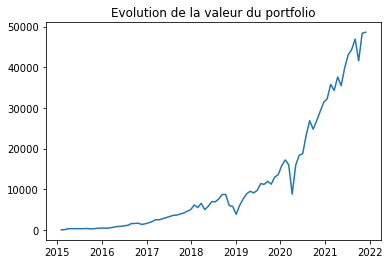

In [22]:
plt.plot(L,argent_fait)
#plt.plot(L,Pf_values)
#plt.plot(L,Cashs)
#plt.yscale("log")
plt.title("Evolution de la valeur du portfolio")
plt.show()

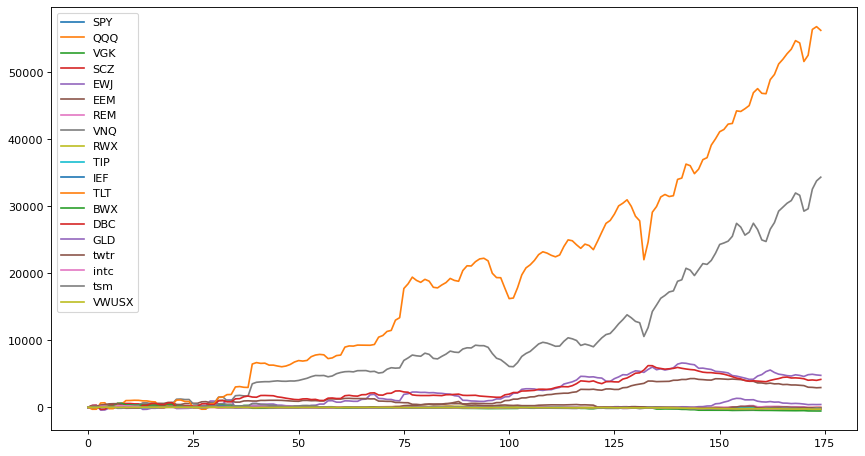

In [20]:
from matplotlib.pyplot import figure

figure(figsize=(13,7), dpi=80)

matrice = np.transpose(np.array(POS))
for i in range(len(matrice)):
    plt.plot(matrice[i],label=assets[i])
plt.legend()
plt.show()

In [21]:
print("Pente moyenne :", int(10000*argent_fait[-1]/(25))/10000,"par période")
LL=[]
for i in range(2,25):
    LL.append((argent_fait[i]-argent_fait[i-1])/argent_fait[i-1])
test = np.array(LL)

Pente moyenne : 1943.6571 par période


Test

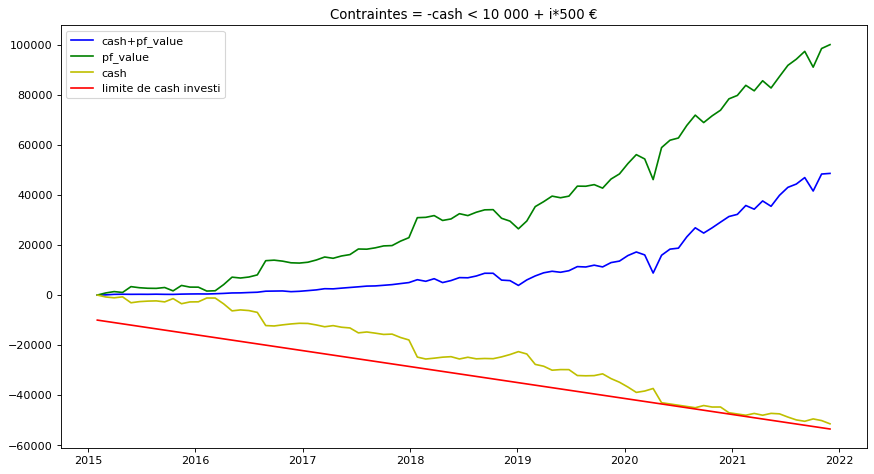

In [24]:
figure(figsize=(13,7), dpi=80)

plt.plot(L,argent_fait,'b', label="cash+pf_value")
plt.plot(L,Pf_values,'g', label="pf_value")
plt.plot(L,Cashs,'y', label="cash")
limcash = [-argent_depart-i*ajout_par_periode for i in range(len(L))]
plt.plot(L,limcash,'r',label="limite de cash investi")
plt.legend()
plt.title("Contraintes = -cash < 10 000 + i*500 €")
plt.show()

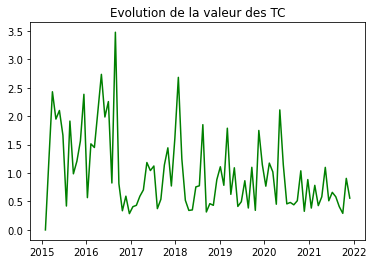

In [27]:
plt.plot(L,TCs,'g')
plt.title("Evolution de la valeur des TC")
#plt.yscale("log")
plt.show()

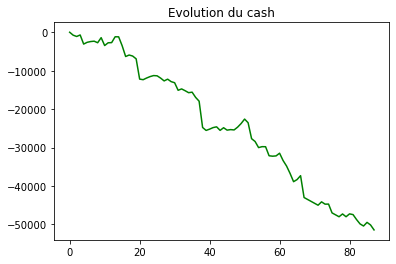

In [29]:
plt.plot(Cashs,'g')
plt.title("Evolution du cash")
plt.show()

Calcul du drawdown

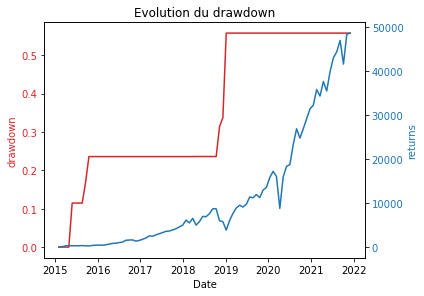

Valeur finale de drawdown : 55.733%


In [37]:
import math

drawdown = -math.inf
maxi = -math.inf
mini = math.inf
i = 0
details = False # afficher plus de détails
dds=[]
for x in argent_fait:
    if x > maxi:
        if details :
            print("max atteint en{}:{}".format(i, argent_fait[i]) )
        maxi = x
        mini = math.inf
    elif x < mini:
        if details:
            print("min atteint en{}:{}".format(i, argent_fait[i]) )
        mini = x
        if maxi != 0:
            drawdown = max(drawdown, (maxi-mini)/maxi)
    dds.append(max(0,drawdown))
    i+=1
    
    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('drawdown', color=color)
ax1.plot(L, dds, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('returns', color=color)  # we already handled the x-label with ax1
ax2.plot(L, argent_fait, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Evolution du drawdown")
plt.show()

print("Valeur finale de drawdown : {}%".format(int(100000*drawdown)/1000))

In [ ]:
pos.round(3)

In [ ]:
plt.plot([pos[i] for i in range(len(pos))])
plt.title("Argent investi dans chaque stock")
plt.show()
print("L'argent est le plus investi dans l'action: "+assets[7])#np.argmax(pos)])

In [ ]:
print("Nombre d'action acheté pour chaque symbols: ")
r = pd.DataFrame([assets,pos])
for i in range(len(assets)):
    print(assets[i],pos[i].round(3))

# Influence de alpha

In [ ]:
D_lamb = []
D = []

alp = [0,0.01,0.05,0.1,0.3,0.6,0.8,1,10]
lambd = 0

for a in alp:
    compute_portfolio(lambd, a, Money, Pos_max_par_actif, jours_returns, periode_trades,999, gain_cible, False)

In [ ]:
from matplotlib.pyplot import figure

U=[]
for x in D:
    if x not in U:
        U.append(x)


figure(figsize=(15, 9), dpi=80)


for i in range(len(U)):
    plt.plot(L,U[i],label=alp[i])
plt.legend()
plt.title('influence de alpha')
plt.show()

# Influence de lambda

In [ ]:
D_lamb = []
D = []

alph = 1
l = [0,0.1,1,10,100]

for lamb in l:
    print("l = {}".format(lamb))
    compute_portfolio(lamb, alph, Money, Pos_max_par_actif, jours_returns, periode_trades,999, dPmax, False)

In [ ]:
from matplotlib.pyplot import figure

U=[]
for x in D:
    if x not in U:
        U.append(x)


figure(figsize=(15, 9), dpi=80)

for i in range(len(U)):
    if l[i] != 0.8:
        plt.plot(L,U[i],label="Lambda = {}".format(l[i]))
plt.legend()
plt.title('influence de lambda, alpha=0')
plt.show()

In [ ]:
import pyfolio as pf
import warnings
from datetime import datetime


warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline


#for i in range(int((all_stocks.shape[0])/periode_trades)):
 #   etape = i*periode_trades
  #  L.append(all_stocks.iloc[etape].name)

returns = pd.DataFrame()
returns['ret'] = argent_fait

returns.index = L

returns = returns['ret'].tz_localize('UTC')
#returns =returns.reindex(index=returns.index[::-1])
returns

In [ ]:
pf.create_full_tear_sheet(returns)